In [1]:
%matplotlib inline
import mhkit
import gridstatus
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import PySAM.Pvwattsv8 as pv

In [2]:
# NDBC data
ndbc_data_file = 'NDBC-46022-2021-spectrum.txt'
# downloaded from https://www.ndbc.noaa.gov/download_data.php?filename=46022w2021.txt.gz&dir=data/historical/swden/
[wave_data,meta] = mhkit.wave.io.ndbc.read_file(ndbc_data_file)
depth = 419 # m
J = mhkit.wave.resource.energy_flux(wave_data.T,depth) # energy flux, W/m


In [3]:
# SAM wave 3-hourly data
url = 'https://raw.githubusercontent.com/NREL/SAM/develop/deploy/wave_resource_ts/lat40.84_lon-124.25__2010.csv'
download = requests.get(url).content
file = io.StringIO(download.decode('utf-8'))
parser = lambda y,m,d,H,M: pd.datetime.strptime(f"{y}.{m}.{d}.{H}.{M}", "%Y.%m.%d.%H.%M")

wave_data_2 = pd.read_csv(file, skiprows = 2, parse_dates={"Time":[0,1,2,3,4]}, date_parser=parser)
wave_data_2 = wave_data_2[['Time','Significant Wave Height','Energy Period']].set_index("Time")
wave_data_2.index = wave_data_2.index.tz_localize('US/Pacific') + pd.offsets.DateOffset(years=11) # fake it starting in 2021
wave_data_2.head()

,Significant Wave Height,Energy Period
Time,,
2021-01-01 00:00:00-08:00,3.21103,9.0149
2021-01-01 03:00:00-08:00,3.13325,9.2803
2021-01-01 06:00:00-08:00,3.32286,8.8879
2021-01-01 09:00:00-08:00,3.35948,8.8694
2021-01-01 12:00:00-08:00,3.33115,9.3399


In [4]:
# Wave energy time series calculation
rho = 1025
g = 9.8
coeff = rho*(g**2)/(64*np.pi)
wave_data_2["J"] = coeff*wave_data_2["Significant Wave Height"]**2*wave_data_2["Energy Period"]
CW = 10 # capture width of WEC, m
wave_data_2["P"] = wave_data_2["J"] * CW # power of WEC, W

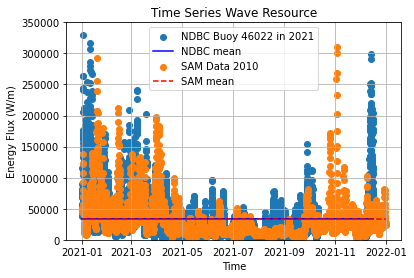

In [5]:
# plot NDBC data alongside SAM data
fig, ax = plt.subplots()

ax.scatter(J.index, J["J"], label='NDBC Buoy 46022 in 2021')
ax.plot(J.index, np.full(np.shape(J.index),J.mean(axis=0)), c='blue', label='NDBC mean')

#plt.xlim([J.index[0], J.index[24]])
plt.ylim([0, 350000])
ax.scatter(wave_data_2.index, wave_data_2["J"], label='SAM Data 2010')
ax.plot(wave_data_2.index, np.full(np.shape(wave_data_2["J"]),wave_data_2["J"].mean(axis=0)), '--', c='red', label='SAM mean')

ax.legend()
ax.set(xlabel='Time', ylabel='Energy Flux (W/m)', title='Time Series Wave Resource')
ax.grid()


In [6]:
# CAISO data
caiso = gridstatus.CAISO()
start = pd.Timestamp("Jan 1, 2021").normalize()
end = pd.Timestamp("Dec 31, 2021").normalize()
#lmp = caiso.get_lmp(start=start, end=end, market='REAL_TIME_HOURLY', 
#                    locations=["EUREKAA_6_N001"])
lmp = pd.read_csv('lmp-eureka-2021.csv',index_col=1)
lmp.index = pd.to_datetime(lmp.index,utc=True).tz_convert('US/Pacific')


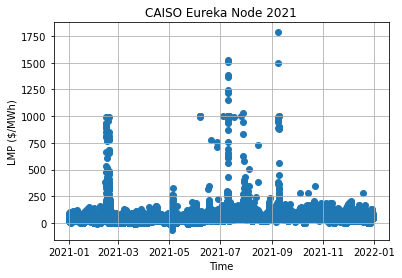

In [7]:
# plot CAISO data
fig, ax = plt.subplots()
ax.scatter(lmp.index, lmp["LMP"])
ax.set(xlabel='Time', ylabel='LMP ($/MWh)', title='CAISO Eureka Node 2021')
ax.grid()

In [8]:
# Get solar and wind data
# for now just copy wave data
solar_data = wave_data_2
wind_data = wave_data_2

system_model = pv.default("PVWattsNone")
#system_model.SolarResource.solar_resource_file = filename
#system_model.execute()
#print(system_model.value('annual_energy_distribution_time'))

In [9]:
# Resample dataframes onto consistent times
dfs = [lmp, wave_data_2, solar_data, wind_data]

# todo: add logic here to account for different end times across datasets
print(wave_data_2.index[-1])
print(lmp.index[-1]>=wave_data_2.index)

lmp = lmp[lmp.index>=wave_data_2.index[-1]]
lmp.tail()

dfs_resampled = [df.resample('15min').mean().interpolate() for df in dfs]
print(dfs_resampled)


2021-12-31 21:00:00-08:00
[ True  True  True ... False False False]
[                           Unnamed: 0  Location Type  ...  Congestion     Loss
Time                                                  ...                     
2021-01-01 00:00:00-08:00         0.0            NaN  ...     0.02888  4.76579
2021-01-01 00:15:00-08:00         1.0            NaN  ...     0.00000  4.17143
2021-01-01 00:30:00-08:00         2.0            NaN  ...     0.14938  4.18565
2021-01-01 00:45:00-08:00         3.0            NaN  ...     0.00000  3.91306
2021-01-01 01:00:00-08:00         4.0            NaN  ...     0.00000  3.40252
...                               ...            ...  ...         ...      ...
2021-12-30 22:45:00-08:00     34827.0            NaN  ...     0.00000  0.00000
2021-12-30 23:00:00-08:00     34828.0            NaN  ...     0.00000 -2.38399
2021-12-30 23:15:00-08:00     34829.0            NaN  ...     0.00000 -2.49846
2021-12-30 23:30:00-08:00     34830.0            NaN  ...     

In [10]:
# Create overall dataframe with all resources
df = pd.DataFrame(index=dfs_resampled[0].index)
dfs_resampled[0].dtypes
df["LMP ($/MWh)"] = dfs_resampled[0]["LMP"]
df["Wave power (W)"] = dfs_resampled[1]["P"]
df["Solar power (W)"] = dfs_resampled[2]["P"]
df["Wind power (W)"] = dfs_resampled[3]["P"]
df.head()

,LMP ($/MWh),Wave power (W),Solar power (W),Wind power (W)
Time,,,,
2021-01-01 00:00:00-08:00,42.40946,455088.458529,455088.458529,455088.458529
2021-01-01 00:15:00-08:00,38.19612,454336.515662,454336.515662,454336.515662
2021-01-01 00:30:00-08:00,38.39243,453584.572795,453584.572795,453584.572795
2021-01-01 00:45:00-08:00,36.49474,452832.629928,452832.629928,452832.629928
2021-01-01 01:00:00-08:00,36.37271,452080.687061,452080.687061,452080.687061


In [11]:
# value of each energy source
W_to_MWh = 15/60 * 1**-6 # for 15min timestep
powers = ['Wave power (W)','Wind power (W)','Solar power (W)']
revenue = W_to_MWh * np.matmul(df[powers].T, df["LMP ($/MWh)"])

print(revenue)

Wave power (W)     1.414669e+11
Wind power (W)     1.414669e+11
Solar power (W)    1.414669e+11
dtype: float64
